In [6]:
from IPython.display import display, Math, Latex, HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os

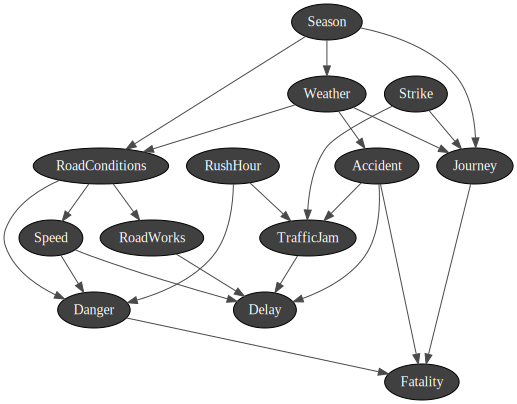

In [34]:
#construct network
m0 = gum.fastBN("Season{Winter|Spring|Summer|Autumn}->Weather{Good|Bad}->RoadConditions{Good|Bad};"
                "RoadConditions->RoadWorks{True|False}->Delay{True|False}<-TrafficJam{True|False}<-Accident{True|False};"
                "Accident->Delay<-Speed{Slow|Fast}<-RoadConditions->Danger{Low|High}->Fatality{True|False};"
                "Fatality<-Journey{True|False}<-Weather->Accident->Fatality;Danger<-RushHour{True|False}->TrafficJam;"
                "TrafficJam<-Strike{True|False}->Journey<-Season->RoadConditions;Speed->Danger")

# OneThird=1/3
# 
# m0.cpt("X")[:]=[OneThird, OneThird, OneThird]
# m0.cpt("Y")[:]=[OneThird, OneThird, OneThird]
# 
# m0.cpt("Z")[{'X':'A','Y':'A'}]=[0,0.5,0.5]
# m0.cpt("Z")[{'X':'B','Y':'B'}]=[0.5,0,0.5]
# m0.cpt("Z")[{'X':'C','Y':'C'}]=[0.5,0.5,0] 
# m0.cpt("Z")[{'X':'A','Y':'B'}]=[0,0,1]
# m0.cpt("Z")[{'X':'A','Y':'C'}]=[0,1,0]
# m0.cpt("Z")[{'X':'B','Y':'A'}]=[0,0,1] 
# m0.cpt("Z")[{'X':'B','Y':'C'}]=[1,0,0]
# m0.cpt("Z")[{'X':'C','Y':'A'}]=[0,1,0]
# m0.cpt("Z")[{'X':'C','Y':'B'}]=[1,0,0]

gnb.showBN(m0, size=10)

#to draw network and cpt
# gnb.sideBySide(m0,m0.cpt("X"),m0.cpt("Y"),m0.cpt("Z"))
